In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from model import HeteroNet_EmbConcatTotal
from dataset import DrugResponse_Dataset
from torch_geometric.loader import DataLoader
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
import seaborn as sns

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

parser = argparse.ArgumentParser()
args, _ = parser.parse_known_args()

args.datadir = os.path.join('/data/project/minwoo/', 'Data')
args.workdir = os.path.join('/data/project/minwoo/', 'feature_selection', 'phase_6_additional_analysis')

args.seed = 1004
args.device = '4'

device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
print('torch version: ', torch.__version__)
print(device)
# ====== Random Seed Initialization ====== #
def seed_everything(seed = 1024):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed=args.seed)

torch version:  2.0.1+cu118
cuda:4


In [2]:
model = HeteroNet_EmbConcatTotal(gnn_embed_dim=128, cell_dim=10000, drug_dim=128,
                            cell_embed_dim=128, drug_embed_dim=128,
                            predictor_hid_dims=[128, 128], predictor_dropout=0.4,
                            k=1000).to(device)

heteronet_fpath = os.path.join(args.workdir, 'HeteroNet_AllConcat_top1000_from_10k_drug_230919_learning_rate0.0001_response_typeIC50.model')
best_model = torch.load(heteronet_fpath)

In [3]:
args.root = os.path.join(args.datadir, 'feature_selection', 'graph_pyg', '20_indirect_targets')
args.data_type = '20_indirect_targets'

In [4]:
response_fpath = os.path.join(args.datadir, 'drug_response', 'response_data_total.tsv')
expression_fpath = os.path.join(args.datadir, 'drug_response', 'expression_10k_genes_data_total.pt')
drug_fp_fpath = os.path.join(args.datadir, 'drug_response', 'drug_data_total.pt')
template_adj_fpath = os.path.join(args.datadir, 'feature_selection', 'template_adjacency_matrix_20_indirect_targets.tsv') ####

In [5]:
expression_data = torch.load(expression_fpath)

gene_list_10k_fpath = os.path.join(args.datadir, 'feature_selection', '10k_gene_names.tsv')
gene_list_10k = pd.read_csv(gene_list_10k_fpath, header=None, sep='\t')
gene_list_10k = gene_list_10k[0].to_list()

In [8]:
# expression_df_fpath = os.path.join(args.datadir, 'drug_response', 'expression_10k_genes_data_total.tsv')
# expression_df = pd.read_csv(expression_df_fpath, sep='\t', index_col=0)

# filename = os.path.join(args.datadir, 'feature_selection', '10k_gene_names.tsv')
# pd.DataFrame(expression_df.columns).to_csv(filename, header=False, index=False)
# gene_list_10k = expression_df.columns.to_list()
expression_df

,FTL,TMSB10,RPS6,S100A6,RPS12,RPS18,EEF1A1,TMSB4X,RPL8,FTH1,...,FAAP100,C7orf57,COG5,C12orf4,GSDMC,LGALS12,TMEM44,SIX5,UGT2B17,ZNF593
cell_name,,,,,,,,,,,,,,,,,,,,,
22RV1,315.89,1584.03,381.88,22.89,680.42,571.06,1384.89,12.36,437.93,57.10,...,9.60,0.03,9.26,10.79,0.00,0.00,0.54,1.53,0.27,1.64
22RV1,315.89,1584.03,381.88,22.89,680.42,571.06,1384.89,12.36,437.93,57.10,...,9.60,0.03,9.26,10.79,0.00,0.00,0.54,1.53,0.27,1.64
22RV1,315.89,1584.03,381.88,22.89,680.42,571.06,1384.89,12.36,437.93,57.10,...,9.60,0.03,9.26,10.79,0.00,0.00,0.54,1.53,0.27,1.64
22RV1,315.89,1584.03,381.88,22.89,680.42,571.06,1384.89,12.36,437.93,57.10,...,9.60,0.03,9.26,10.79,0.00,0.00,0.54,1.53,0.27,1.64
22RV1,315.89,1584.03,381.88,22.89,680.42,571.06,1384.89,12.36,437.93,57.10,...,9.60,0.03,9.26,10.79,0.00,0.00,0.54,1.53,0.27,1.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
huH-1,14096.40,1043.52,143.93,1421.67,1154.49,582.40,1573.87,128.78,482.29,551.62,...,3.88,0.04,5.29,4.23,0.03,0.01,3.29,2.55,0.00,1.56
huH-1,14096.40,1043.52,143.93,1421.67,1154.49,582.40,1573.87,128.78,482.29,551.62,...,3.88,0.04,5.29,4.23,0.03,0.01,3.29,2.55,0.00,1.56
huH-1,14096.40,1043.52,143.93,1421.67,1154.49,582.40,1573.87,128.78,482.29,551.62,...,3.88,0.04,5.29,4.23,0.03,0.01,3.29,2.55,0.00,1.56


In [6]:
response_data = pd.read_csv(response_fpath, sep='\t')
response_data = response_data.reset_index().rename(columns={'index':'idx'})
response_data

,idx,cell_name,drug_name,IC50,AUC
0,0,22RV1,AR-42,-1.781237,0.405059
1,1,22RV1,AT-7519,1.157396,0.727414
2,2,22RV1,AT13148,2.378729,0.849915
3,3,22RV1,AZ6102,2.771439,0.875301
4,4,22RV1,AZD1208,5.003845,0.951280
...,...,...,...,...,...
168239,168239,huH-1,SN-38,-4.249504,0.715832
168240,168240,huH-1,Sabutoclax,1.602325,0.773917
168241,168241,huH-1,Staurosporine,-1.814190,0.531221
168242,168242,huH-1,Talazoparib,5.514632,0.961915


In [7]:
target_info_fpath = os.path.join(args.datadir, 'drug_response', 'dti_info_final_common_drugs_only.tsv')
target_info = pd.read_csv(target_info_fpath, sep='\t')
target_info

,gene_name,drug_id,drug_name,Target pathway
0,ABL1,DB00619,Imatinib,NaN
1,ABL1,DB01254,Dasatinib,NaN
2,ABL1,DB04868,Nilotinib,NaN
3,ABL1,DB06616,Bosutinib,NaN
4,ABL1,DB08901,Ponatinib,NaN
...,...,...,...,...
617,PORCN,NaN,Wnt-C59,WNT signaling
618,TNKS2,NaN,XAV939,WNT signaling
619,PIKFYVE,NaN,YM201636,PI3K/MTOR signaling
620,AURKA,NaN,ZM447439,Mitosis


In [8]:
drug2path = dict(zip(target_info['drug_name'], target_info['Target pathway']))
response_data['pathway'] = response_data['drug_name'].map(drug2path)
response_data

,idx,cell_name,drug_name,IC50,AUC,pathway
0,0,22RV1,AR-42,-1.781237,0.405059,Chromatin histone acetylation
1,1,22RV1,AT-7519,1.157396,0.727414,Cell cycle
2,2,22RV1,AT13148,2.378729,0.849915,PI3K/MTOR signaling
3,3,22RV1,AZ6102,2.771439,0.875301,WNT signaling
4,4,22RV1,AZD1208,5.003845,0.951280,"Other, kinases"
...,...,...,...,...,...,...
168239,168239,huH-1,SN-38,-4.249504,0.715832,DNA replication
168240,168240,huH-1,Sabutoclax,1.602325,0.773917,Apoptosis regulation
168241,168241,huH-1,Staurosporine,-1.814190,0.531221,NaN
168242,168242,huH-1,Talazoparib,5.514632,0.961915,NaN


In [9]:
drug_data = torch.load(drug_fp_fpath)
adjacency_matrix = pd.read_csv(template_adj_fpath, sep='\t', index_col=0, header=0)

total_dataset = DrugResponse_Dataset(response_data, expression_data, drug_data, adjacency_matrix, 
                                        root=args.root, data_type=args.data_type)

/data/project/minwoo/Data/feature_selection/graph_pyg/20_indirect_targets/raw
/data/project/minwoo/Data/feature_selection/graph_pyg/20_indirect_targets/processed


In [10]:
args.split_by = 'drug'
args.test_size = 0.2

In [11]:
from sklearn.model_selection import train_test_split, KFold

# ========================================== #
# ====== CV: Train/Valid & Test Split ====== #
# ========================================== #
if args.split_by == 'drug':
    split_entity_list = response_data['drug_name'].unique()
elif args.split_by == 'cell':
    split_entity_list = response_data['cell_name'].unique()
# elif args.split_by == 'mix' or args.split_by == 'both':
#     split_entity_list = response_data['idx'].values
else:
    raise ValueError('split_by should be one of [drug, cell, mix, both]')
print("#Entity:", len(split_entity_list))

# === Train/Valid vs. Test Split === #
train_valid_entities, test_entities = train_test_split(split_entity_list, test_size=args.test_size, random_state=1004)

kfold = KFold(n_splits=2, shuffle=True)

for fold, (train_entity_ids, valid_entity_ids) in enumerate(kfold.split(train_valid_entities)):
    break

idx = 0

#Entity: 227


In [12]:
if args.split_by == 'drug':
    test_idxs = response_data.query('drug_name in @test_entities')['idx'].to_list()

    train_drugs = train_valid_entities[train_entity_ids]
    valid_drugs = train_valid_entities[valid_entity_ids]

    train_idxs = response_data.query('drug_name in @train_drugs')['idx'].to_list()
    valid_idxs = response_data.query('drug_name in @valid_drugs')['idx'].to_list()
elif args.split_by == 'cell':
    test_idxs = response_data.query('cell_name in @test_entities')['idx'].to_list()

    train_cells = train_valid_entities[train_entity_ids]
    valid_cells = train_valid_entities[valid_entity_ids]

    train_idxs = response_data.query('cell_name in @train_cells')['idx'].to_list()
    valid_idxs = response_data.query('cell_name in @valid_cells')['idx'].to_list()
elif args.split_by == 'mix':
    test_idxs = list(test_entities)

    train_idxs = list(train_valid_entities[train_entity_ids])
    valid_idxs = list(train_valid_entities[valid_entity_ids])
elif args.split_by == 'both':
    # === Cell Split === #
    cell_list = list(response_data['cell_name'].unique())
    n_train_cell = math.floor(len(cell_list) * 0.7)
    n_valid_cell = (len(cell_list) - n_train_cell) // 2
    n_test_cell = len(cell_list) - n_train_cell - n_valid_cell
    print(f"#Train Cell lines: {n_train_cell},\t #Valid Cell lines: {n_valid_cell}\t #Test Cell lines: {n_test_cell}")
    print(f"#Total: {n_train_cell + n_valid_cell + n_test_cell}")

    train_cells = random.sample(cell_list, k=n_train_cell)
    rest_cells = [cell for cell in cell_list if cell not in train_cells]
    valid_cells = random.sample(rest_cells, k=n_valid_cell)
    test_cells = [cell for cell in rest_cells if cell not in valid_cells]

    # === Drug Split === #
    drug_list = list(response_data['drug_name'].unique())
    n_train_drug = math.floor(len(drug_list) * 0.7)
    n_valid_drug = (len(drug_list) - n_train_drug) // 2
    n_test_drug = len(drug_list) - n_train_drug - n_valid_drug
    print(f"#Train Drug lines: {n_train_drug},\t #Valid Drug lines: {n_valid_drug}\t #Test Drug lines: {n_test_drug}")
    print(f"#Total: {n_train_drug + n_valid_drug + n_test_drug}")

    train_drugs = random.sample(drug_list, k=n_train_drug)
    rest_drugs = [drug for drug in drug_list if drug not in train_drugs]
    valid_drugs = random.sample(rest_drugs, k=n_valid_drug)
    test_drugs = [drug for drug in rest_drugs if drug not in valid_drugs]

    # === Get Indexes === #
    train_idxs = response_data.query('cell_name in @train_cells and drug_name in @train_drugs')['idx'].to_list()
    valid_idxs = response_data.query('cell_name in @valid_cells and drug_name in @valid_drugs')['idx'].to_list()
    test_idxs  = response_data.query('cell_name in @test_cells and drug_name in @test_drugs')['idx'].to_list()

print(f'FOLD {fold}')

FOLD 0


In [13]:
args.batch_size = 12

# Subset the data
train_set = torch.utils.data.Subset(total_dataset, train_idxs)
valid_set = torch.utils.data.Subset(total_dataset, valid_idxs)
test_set  = torch.utils.data.Subset(total_dataset, test_idxs)

# === Data Loader === #
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_set, batch_size=args.batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [14]:
# loss_fn = nn.MSELoss()

model.eval()
list_exp_mask = []
list_exp_data = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = tuple(d.to(device) for d in data)
    true_y = target.to(device)
    
    # pred_y = model(data)
    pred_y, similarity_vector, mask, topk_indices = model.get_mask(data)
    graph, exp, drug = data
    # loss = loss_fn(pred_y, true_y)
    
    list_exp_mask.append(mask.detach().cpu().numpy())
    list_exp_data.append(exp.detach().cpu().numpy())

In [15]:
# === Subset Response df to Test Set === #
response_data_test = response_data.query('idx in @test_idxs').reset_index(drop=True)

In [16]:
list_exp_mask = np.vstack(list_exp_mask)
list_exp_data = np.vstack(list_exp_data)

In [17]:
list_exp_mask.shape, list_exp_data.shape

((33351, 10000), (33351, 10000))

In [18]:
exp_mask_df = pd.DataFrame(list_exp_mask)
exp_mask_df.columns = gene_list_10k
exp_data_df = pd.DataFrame(list_exp_data)
exp_data_df.columns = gene_list_10k

In [19]:
exp_mask_df

,FTL,TMSB10,RPS6,S100A6,RPS12,RPS18,EEF1A1,TMSB4X,RPL8,FTH1,...,FAAP100,C7orf57,COG5,C12orf4,GSDMC,LGALS12,TMEM44,SIX5,UGT2B17,ZNF593
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33346,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33347,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33348,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33349,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Enrichment with Selected Genes

In [20]:
pathways = response_data_test['pathway'].value_counts().index.to_list()
pathways

['Other, kinases',
 'RTK signaling',
 'Cell cycle',
 'WNT signaling',
 'IGF1R signaling',
 'PI3K/MTOR signaling',
 'Chromatin histone methylation',
 'Chromatin histone acetylation',
 'Apoptosis regulation',
 'Other']

In [21]:
# filter response_data_test where pathway is not null
drug_list = list(response_data_test[response_data_test['pathway'].notna()]['drug_name'].unique())

In [22]:
for drug in drug_list:
    pass
drug = drug_list[0]    ####
pathway = response_data_test.query('drug_name == @drug')['pathway'].values[0]
print("Pathway:", pathway, "Drug:", drug)
# for pathway in pathways:
#     pass
# pathway = pathways[8]

# === Get Top 1000 Genes Mask === #
# pathway_response_df = response_data_test.query('pathway == @pathway')
pathway_response_df = response_data_test.query('drug_name == @drug')
pathway_response_df

Pathway: Cell cycle Drug: AT-7519


,idx,cell_name,drug_name,IC50,AUC,pathway
0,1,22RV1,AT-7519,1.157396,0.727414,Cell cycle
35,174,23132-87,AT-7519,0.770189,0.689046,Cell cycle
70,346,42-MG-BA,AT-7519,2.153142,0.856262,Cell cycle
105,519,5637,AT-7519,0.352058,0.631964,Cell cycle
140,692,639-V,AT-7519,1.850502,0.849678,Cell cycle
...,...,...,...,...,...,...
27099,133424,WSU-NHL,AT-7519,1.641867,0.818999,Cell cycle
27136,133605,YAPC,AT-7519,0.767505,0.669725,Cell cycle
27171,133778,YH-13,AT-7519,1.231873,0.752521,Cell cycle
27206,133951,YT,AT-7519,1.859672,0.849021,Cell cycle


In [23]:
pathway_mask = exp_mask_df.iloc[pathway_response_df.index]
assert pathway_response_df.shape[0] == pathway_mask.shape[0]
assert (pathway_response_df.index == pathway_mask.index).all()

In [43]:
pathway_mask.sum(axis=0).sort_values(ascending=False).head(20)

RPS3A        747.0
RPLP2        747.0
RPS2         747.0
EEF2         747.0
RPS20        747.0
RPL29        747.0
RPL27        747.0
RPL5         747.0
RPL10A       747.0
ILF2         747.0
RPS14        747.0
RPS25        747.0
RPS19        747.0
RPL36        747.0
YWHAQ        747.0
CNBP         747.0
RHOA         747.0
NCL          747.0
HNRNPA2B1    747.0
FAU          747.0
dtype: float32

In [57]:
pathway_mask_genes = pathway_mask.sum(axis=0).sort_values(ascending=False).iloc[:1000].index.to_list()

In [60]:
# gp.get_library_name(organism='Human')
args.enrichr_outdir = os.path.join(args.workdir, 'enrich_results', drug)
createFolder(args.enrichr_outdir)
gp_res = gp.enrichr(gene_list = pathway_mask_genes, 
                    gene_sets = ['KEGG_2019_Human'], #, 'Reactome_2022'
                    organism='Human', 
                    outdir=args.enrichr_outdir, 
                    cutoff=0.05)

In [61]:
# kegg_df = pd.read_csv(os.path.join(args.workdir, 'enrich_results', 'AT-7519', 'KEGG_2019_Human.Human.enrichr.reports.txt'), sep='\t', header=0, index_col=None)
print("Pathway:", pathway, "Drug:", drug)
kegg_df = gp_res.results
kegg_df

Pathway: Cell cycle Drug: AT-7519


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Ribosome,80/153,7.703789e-63,2.133950e-60,0,0,22.545563,3.224492e+03,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;R...
1,KEGG_2019_Human,Pathogenic Escherichia coli infection,23/55,3.759845e-16,5.207385e-14,0,0,13.954197,4.956110e+02,ITGB1;ARPC1B;TUBB;ARPC1A;TUBB4B;CLDN1;YWHAZ;AC...
2,KEGG_2019_Human,Focal adhesion,41/199,6.559081e-15,6.056218e-13,0,0,5.098415,1.665037e+02,ITGB1;SHC1;ITGB4;TNC;LAMC2;LAMC1;THBS2;THBS1;A...
3,KEGG_2019_Human,Phagosome,35/152,1.876428e-14,1.299426e-12,0,0,5.853638,1.850149e+02,ITGB1;TFRC;THBS2;MPO;CORO1A;THBS1;ACTB;ACTG1;C...
4,KEGG_2019_Human,ECM-receptor interaction,25/82,1.093682e-13,6.059001e-12,0,0,8.521368,2.543122e+02,ITGB1;SDC4;ITGB4;TNC;LAMC2;LAMC1;THBS2;THBS1;S...
...,...,...,...,...,...,...,...,...,...,...
272,KEGG_2019_Human,Lysine degradation,1/59,9.517221e-01,9.656667e-01,0,0,0.326913,1.617640e-02,ECHS1
273,KEGG_2019_Human,Ubiquitin mediated proteolysis,3/137,9.702000e-01,9.808227e-01,0,0,0.423644,1.281651e-02,CDC20;UBE2C;UBE2S
274,KEGG_2019_Human,Inositol phosphate metabolism,1/74,9.776904e-01,9.848009e-01,0,0,0.259534,5.855645e-03,TPI1
275,KEGG_2019_Human,Glycerophospholipid metabolism,1/97,9.931766e-01,9.967750e-01,0,0,0.197114,1.349599e-03,PLA2G2A


In [4]:
related_terms = ['Cycle', 'Apoptosis', 'mTOR', 'Ferroptosis', 'MAPK', 'AMPK']

# === Fetch Related Terms === #
def is_term(term, keyword):
    if keyword.lower() in term.lower():
        return True
    else:
        return False

kegg_related = []

for keyword in related_terms:
    tmp_df = kegg_df[kegg_df['Term'].apply(is_term, args=(keyword,))]
    kegg_related.append(tmp_df)

kegg_related = pd.concat(kegg_related).query('`Adjusted P-value` < 0.05')
kegg_related['inv_log'] = kegg_related['Adjusted P-value'].apply(lambda x: -np.log10(x))
kegg_related = kegg_related.sort_index()
# kegg_related = kegg_related.reset_index()
# kegg_related = kegg_related.rename(columns = {"index": "rank"})
kegg_related

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,inv_log
27,KEGG_2019_Human,Apoptosis,24/143,1.703395e-07,0.000002,0,0,3.901570,60.807820,JUN;PARP1;CTSZ;PRF1;GZMB;FOS;ACTB;ACTG1;NFKBIA...,5.773363
59,KEGG_2019_Human,Cell cycle,17/124,1.477502e-04,0.000682,0,0,3.053603,26.932740,YWHAE;CDKN1A;PCNA;MCM7;YWHAB;CDC6;YWHAZ;CDC20;...,3.166143
72,KEGG_2019_Human,Ferroptosis,8/40,6.997872e-04,0.002655,0,0,4.780242,34.727190,PRNP;TFRC;GPX4;PCBP1;FTH1;SLC3A2;SAT1;FTL,2.575877
115,KEGG_2019_Human,MAPK signaling pathway,24/295,1.338234e-02,0.031956,0,0,1.699443,7.331092,HSPA8;JUN;JUND;DUSP1;IGF2;HSPB1;FOS;GNG12;AREG...,1.495446
119,KEGG_2019_Human,Citrate cycle (TCA cycle),5/30,1.555660e-02,0.035613,0,0,3.814070,15.879010,ACLY;FH;MDH2;IDH1;IDH2,1.448391


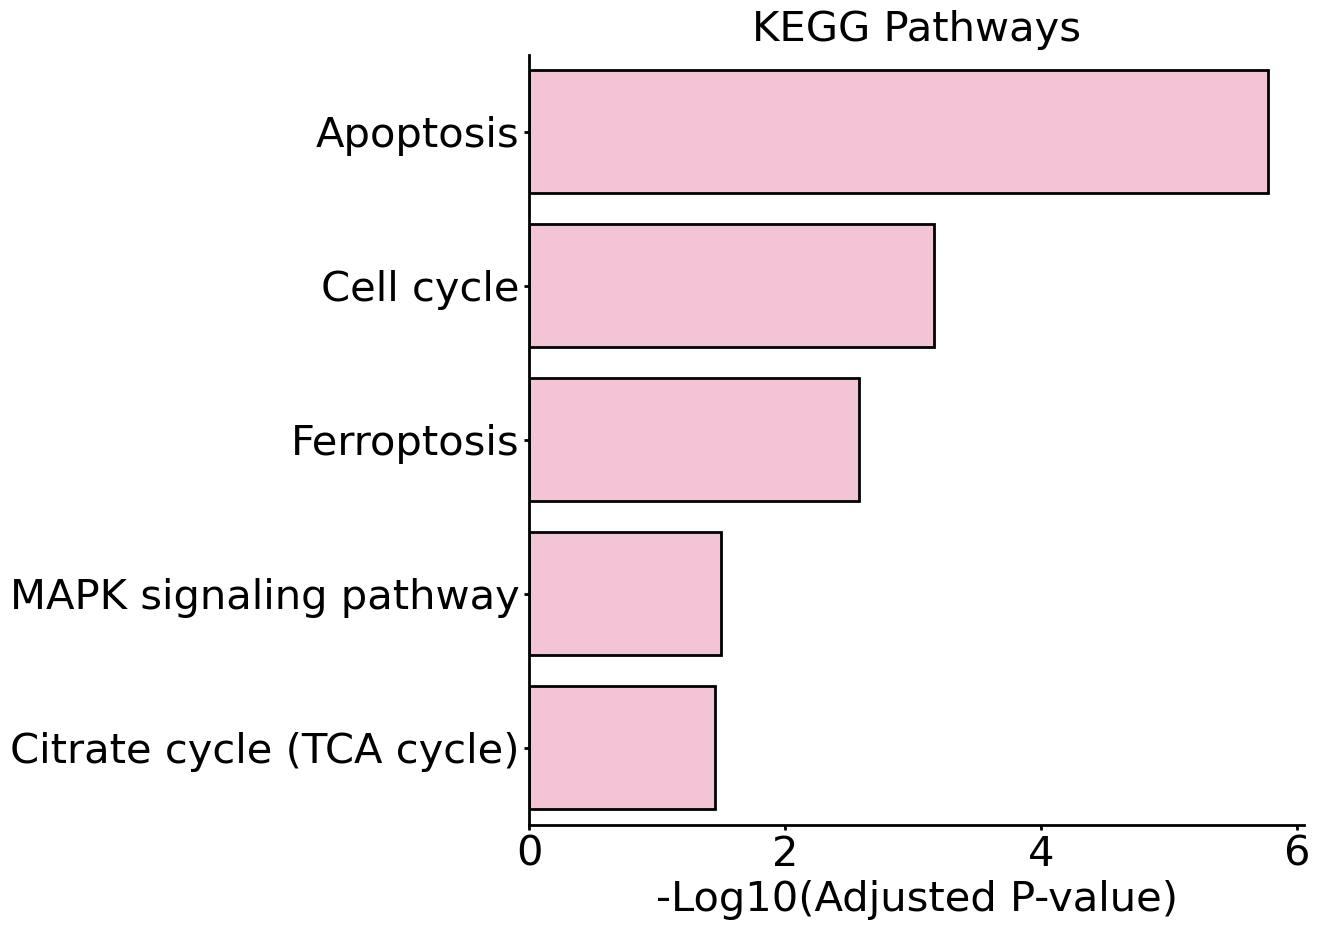

In [9]:
fig = plt.figure(figsize=(10, 10))
fig.tight_layout();
ax = fig.add_subplot(1, 1, 1);

sns.barplot(x=kegg_related['inv_log'], y=kegg_related["Term"], color='#fabcd4', edgecolor='k')
plt.title("KEGG Pathways", fontsize=30,  fontweight=550, pad=10)
plt.xlabel('-Log10(Adjusted P-value)', fontsize=30, fontweight=550)
plt.ylabel('')

plt.setp(ax.patches, linewidth=2)
ax.tick_params(width=2)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)

In [89]:
for drug in drug_list:
    pass
drug = drug_list[7]    ####
pathway = response_data_test.query('drug_name == @drug')['pathway'].values[0]
print("Pathway:", pathway, "Drug:", drug)

Pathway: PI3K/MTOR signaling Drug: MK-2206


In [90]:
# === Get Top 1000 Genes Mask === #
pathway_response_df = response_data_test.query('drug_name == @drug')

pathway_mask = exp_mask_df.iloc[pathway_response_df.index]
assert pathway_response_df.shape[0] == pathway_mask.shape[0]
assert (pathway_response_df.index == pathway_mask.index).all()

pathway_mask_genes = pathway_mask.sum(axis=0).sort_values(ascending=False).iloc[:1000].index.to_list()

# gp.get_library_name(organism='Human')
args.enrichr_outdir = os.path.join(args.workdir, 'enrich_results', drug)
createFolder(args.enrichr_outdir)
gp_res = gp.enrichr(gene_list = pathway_mask_genes, 
                    gene_sets = ['KEGG_2019_Human'], #, 'Reactome_2022'
                    organism='Human', 
                    outdir=args.enrichr_outdir, 
                    cutoff=0.05)

print("Pathway:", pathway, "Drug:", drug)
# kegg_df = pd.read_csv(os.path.join(args.workdir, 'enrich_results', 'MK-2206', 'KEGG_2019_Human.Human.enrichr.reports.txt'), sep='\t', header=0, index_col=None)
# font = {'family' : 'DejaVu Sans',
#         'weight' : 'normal',
#         'size'   : 30}
# matplotlib.rc('font', **font)
kegg_df = gp_res.results

Pathway: PI3K/MTOR signaling Drug: MK-2206


In [11]:
related_terms = ['PI3K', 'Apoptosis', 'mTOR', 'MAPK', 'AMPK', 'Lung', 'Prostate', 'Carcinoma']

# === Fetch Related Terms === #
def is_term(term, keyword):
    if keyword.lower() in term.lower():
        return True
    else:
        return False

kegg_related = []

for keyword in related_terms:
    tmp_df = kegg_df[kegg_df['Term'].apply(is_term, args=(keyword,))]
    kegg_related.append(tmp_df)

kegg_related = pd.concat(kegg_related).query('`Adjusted P-value` < 0.05')

if kegg_related.shape[0] < 5:
    # make kegg_related to be 5
    required_num_rows = 5 - kegg_related.shape[0]
    tmp_df = kegg_df.iloc[:required_num_rows]
    kegg_related = pd.concat([kegg_related, tmp_df])
elif kegg_related.shape[0] > 5:
    kegg_related = kegg_related.iloc[:5]

assert kegg_related.shape[0] == 5
kegg_related['inv_log'] = kegg_related['Adjusted P-value'].apply(lambda x: -np.log10(x))
kegg_related = kegg_related.sort_index()
kegg_related

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,inv_log
7,KEGG_2019_Human,PI3K-Akt signaling pathway,53/354,7.692091e-13,2.663386e-11,0,0,3.476785,96.979390,YWHAE;ITGB1;CDKN1A;HSP90AB1;YWHAB;ITGB4;TNC;LA...,10.574566
27,KEGG_2019_Human,Apoptosis,24/143,1.703395e-07,1.685144e-06,0,0,3.901570,60.807820,JUN;PARP1;CTSZ;PRF1;GZMB;FOS;ACTB;ACTG1;NFKBIA...,5.773363
38,KEGG_2019_Human,Small cell lung cancer,18/93,6.815135e-07,4.840494e-06,0,0,4.625255,65.673760,ITGB1;CDKN1A;LAMB3;ITGA3;FN1;LAMC2;LAMB1;LAMC1...,5.315110
48,KEGG_2019_Human,Prostate cancer,17/97,5.739510e-06,3.244580e-05,0,0,4.090031,49.359050,CDKN1A;HSP90AA1;HSP90AB1;GSTP1;MMP3;PLAT;KLK3;...,4.488842
115,KEGG_2019_Human,MAPK signaling pathway,24/295,1.338234e-02,3.195610e-02,0,0,1.699443,7.331092,HSPA8;JUN;JUND;DUSP1;IGF2;HSPB1;FOS;GNG12;AREG...,1.495446


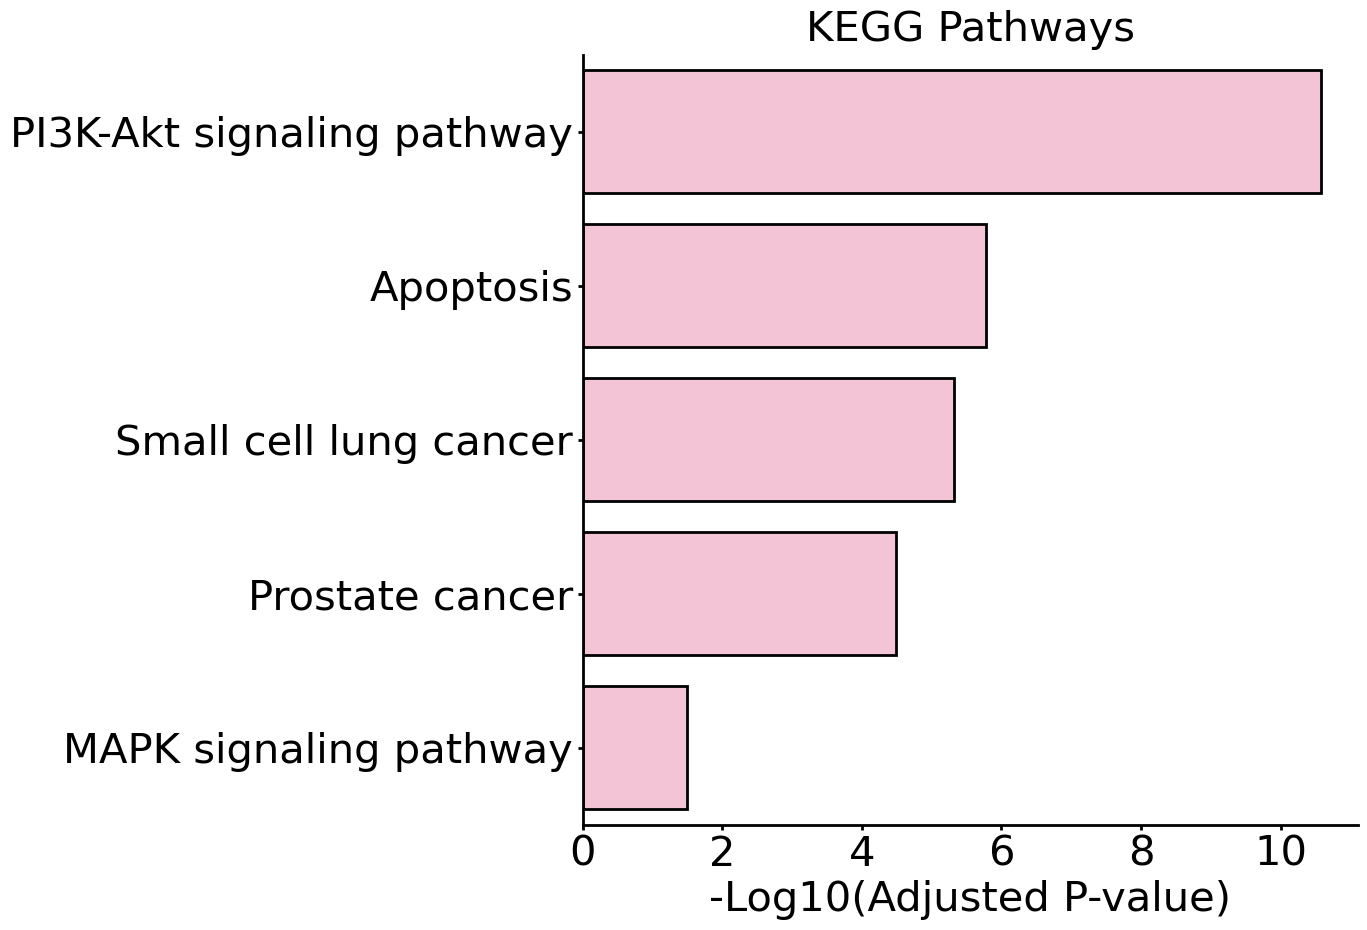

In [12]:
fig = plt.figure(figsize=(10, 10))
fig.tight_layout();
ax = fig.add_subplot(1, 1, 1);

sns.barplot(x=kegg_related['inv_log'], y=kegg_related["Term"], color='#fabcd4', edgecolor='k')
plt.title("KEGG Pathways", fontsize=30,  fontweight=550, pad=10)
plt.xlabel('-Log10(Adjusted P-value)', fontsize=30, fontweight=550)
plt.ylabel('')

plt.setp(ax.patches, linewidth=2)
ax.tick_params(width=2)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)

---

In [28]:
target_info.query('drug_name == @drug')

,gene_name,drug_id,drug_name,Target pathway
202,CDK2,DB08142,AT-7519,NaN
204,CDK1,DB08142,AT-7519,NaN
387,CDK4,NaN,AT-7519,Cell cycle
388,CDK6,NaN,AT-7519,Cell cycle
389,CDK9,NaN,AT-7519,Cell cycle


In [149]:
def check_and_print_string_in_list(lst, string):
    matching_elements = [item for item in lst if string.lower() in item.lower()]
    for element in matching_elements:
        print(element)

    return bool(matching_elements)

check_and_print_string_in_list(pathway_mask_genes, 'bc')

UBC


True

In [87]:
response_data_test['pathway'].value_counts()

pathway
Other, kinases                   3781
RTK signaling                    3349
Cell cycle                       2322
WNT signaling                    1465
IGF1R signaling                   802
PI3K/MTOR signaling               799
Chromatin histone methylation     796
Chromatin histone acetylation     750
Apoptosis regulation              746
Other                             315
Name: count, dtype: int64